In [1]:
import functools

import diffrax
import equinox
import jax
import optax
import scipy.stats

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import numpy as np
from matplotlib.figure import Figure
from tqdm.notebook import trange

%matplotlib inline

# Simulate stochastic Lorenz system

In [2]:
@jax.jit
def F_true(x, key, σ=2, T=0.05, dt=1e-2, tol=1e-3):
    # Lorenz parameters
    sigma = 10.0
    rho = 28.0
    beta = 8 / 3

    # Drift function f(t, y)
    def drift(t, y, _args):
        x, y_, z = y
        dx = sigma * (y_ - x)
        dy = x * (rho - z) - y_
        dz = x * y_ - beta * z
        return jnp.array([dx, dy, dz])

    # Diffusion function g(t, y)
    def diffusion(t, y, _args):
        return jnp.eye(3) * σ

    # SDE solver
    solver = diffrax.ShARK()

    # Solve
    bm = diffrax.VirtualBrownianTree(
        t0=0, t1=T, tol=tol, shape=(3,), key=key, levy_area=diffrax.SpaceTimeLevyArea
    )
    # Set up the SDE
    sde = diffrax.MultiTerm(diffrax.ODETerm(drift), diffrax.ControlTerm(diffusion, bm))
    # Solve the SDE
    sol = diffrax.diffeqsolve(
        sde,
        solver=solver,
        t0=0,
        t1=T,
        dt0=dt,
        y0=x,
        # saveat=diffrax.SaveAt(ts=ts),
        max_steps=10000,
    )
    return sol.ys

In [3]:
# big steps
lorenz_args = dict(σ=2.0, T=0.5, dt=1e-2, tol=1e-3)

In [4]:
F_true_train_and_test = jax.jit(jax.vmap(functools.partial(F_true, **lorenz_args)))

In [5]:
N = 10000

keys = jax.random.split(jax.random.PRNGKey(3), (N, 2))
x_train_and_test = np.zeros((N, 2, 3))
x_train_and_test[0, :, :] = [-8.0, 4.0, 27.0]
for i in trange(1, N):
    x_train_and_test[i, :, :] = F_true_train_and_test(
        x_train_and_test[i - 1, :], keys[i - 1, :]
    ).squeeze()

  0%|          | 0/9999 [00:00<?, ?it/s]

In [6]:
x_train = x_train_and_test[:, 0, :]
x_test = x_train_and_test[:, 1, :]

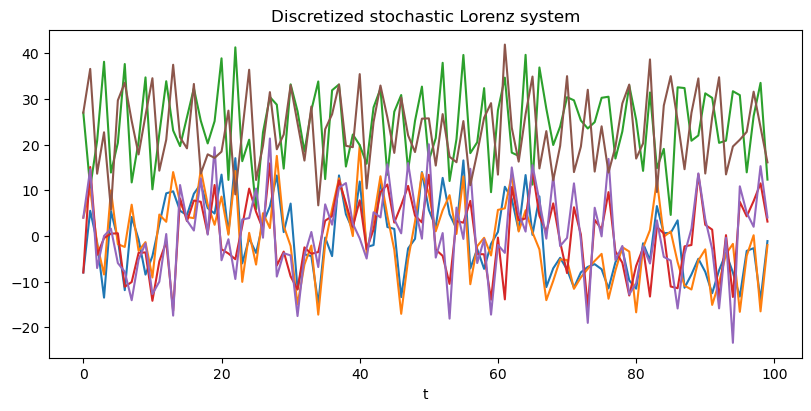

In [7]:
fig = Figure(figsize=(8, 4), dpi=100, constrained_layout=1)
ax = fig.gca()
ax.plot(x_train[:100])
ax.plot(x_test[:100])
ax.set_title("Discretized stochastic Lorenz system")
ax.set_xlabel("t")
fig

# Learn a deep neural approximation to F

In [8]:
import os
import sys

import equinox

lib_path = os.path.join(os.path.curdir, "src")
sys.path.insert(0, lib_path)
import importlib

import probit_network
import random_matrix
import unscented

importlib.reload(unscented)
importlib.reload(random_matrix)
importlib.reload(probit_network)
from probit_network import ProbitLinear, ProbitLinearNetwork
from random_matrix import RandomGaussian, RandomOrthogonalProjection, ZeroMatrix

Network architecure with two hidden layers of 100 neurons each

In [10]:
n_x = 3
n_hidden = 50
# TODO why does calling this network break on GPU
network = ProbitLinearNetwork(
    ProbitLinear.create_probit(
        in_size=n_x,
        out_size=n_hidden,
        key=jax.random.PRNGKey(1),
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
    ),
    ProbitLinear.create_residual(
        in_size=n_hidden,
        out_size=n_hidden,
        key=jax.random.PRNGKey(2),
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
    ),
    ProbitLinear.create_residual(
        in_size=n_hidden,
        out_size=n_hidden,
        key=jax.random.PRNGKey(3),
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
    ),
    ProbitLinear.create_linear(
        in_size=n_hidden,
        out_size=n_x,
        C=RandomOrthogonalProjection(),
        d=RandomOrthogonalProjection(),
    ),
)

Least-squares loss

In [11]:
@jax.jit
def get_loss(model, x_time_series):
    pred_x = jax.vmap(model)(x_time_series[:-1])
    actual_x = x_time_series[1:]
    return jnp.mean((pred_x - actual_x) ** 2)


loss_value_and_grad = equinox.filter_value_and_grad(get_loss)

AdamW optimizer with lightly hand-tuned training hyperparameters

In [12]:
opt = optax.adamw(learning_rate=1e-3, b1=0.9, b2=0.99)

opt_state = opt.init(network)

@equinox.filter_jit
def step(model, x, opt_state):
    loss, grads = loss_value_and_grad(model, x)
    updates, opt_state = opt.update(grads, opt_state, params=model)
    model = equinox.apply_updates(model, updates)
    return loss, model, opt_state

In [13]:
loss_history = []

In [14]:
from tqdm.notebook import tqdm

In [15]:
pbar = trange(1000)
# optional GPU acceleration (not much faster but relieves CPU workload)
with jax.default_device(jax.devices("gpu")[0]):
    for i in pbar:
        loss, network, opt_state = step(network, x_train, opt_state)
        test_loss = get_loss(network, x_test)
        loss_history.append((loss, test_loss))
        if i % 10 == 0:
            train_rmse = loss.item() ** 0.5
            test_rmse = test_loss.item() ** 0.5
            pbar.set_postfix({"rmse": f"{train_rmse:.6f}, {test_rmse:.6f}"})

  0%|          | 0/1000 [00:00<?, ?it/s]

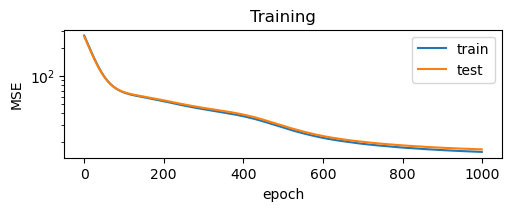

In [16]:
fig = Figure(figsize=(5, 2), constrained_layout=1)
ax = fig.gca()
ax.plot(loss_history, label=["train", "test"])
ax.legend()
ax.set_title("Training")
ax.set_ylabel("MSE")
ax.set_xlabel("epoch")
ax.set_yscale("log")
fig

Estimate process covariance using prediction residuals

In [17]:
residual = jax.vmap(network)(x_test[:-1]) - x_test[1:]
Q_0 = jax.vmap(jnp.outer)(residual, residual).mean(axis=0)
print("Q eigenvalues", np.linalg.eigvalsh(Q_0))

Q eigenvalues [ 1.69158721 19.71949734 28.09350343]


Predict a sample trajectory

In [18]:
x_pred = np.zeros((N, 3))
x_pred[0] = x_test[0]
for i in trange(1, N):
    x_pred[i, :] = network(x_pred[i - 1, :])

  0%|          | 0/9999 [00:00<?, ?it/s]

Preview the tail of the trajectory (the end is more sensitive to degeneracy than the beginning)

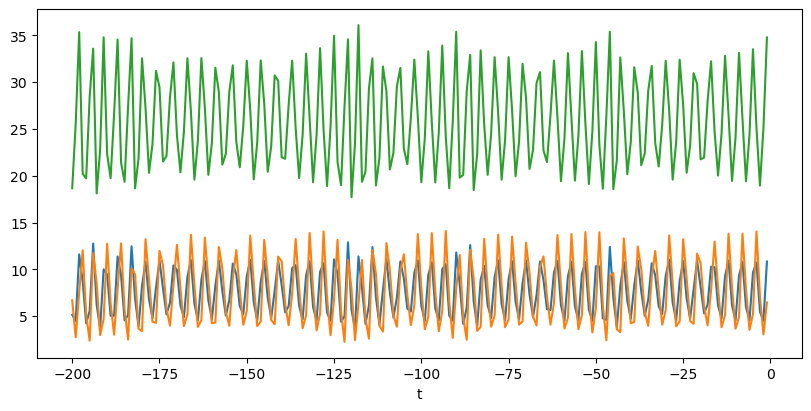

In [19]:
fig = Figure(figsize=(8, 4), dpi=100, constrained_layout=1)
ax = fig.gca()
ax.plot(np.arange(-200, 0), x_pred[-200:])
ax.set_xlabel("t")
fig

# UQ: propagate $\mathcal N(x_0, Q)$ through $\hat F$

In [20]:
μ_in = x_train[0]
Σ_in = Q_0

In [21]:
input_samples = scipy.stats.qmc.MultivariateNormalQMC(
    mean=μ_in, cov=Σ_in, rng=10
).random(2**10)

output_samples = jax.vmap(network)(input_samples)

In [22]:
μ_unscented, Σ_unscented = network.propagate_mean_cov(μ_in, Σ_in, method="unscented")
μ_linear, Σ_linear = network.propagate_mean_cov(μ_in, Σ_in, method="linear")
μ_analytic, Σ_analytic = network.propagate_mean_cov(μ_in, Σ_in, method="analytic")

In [23]:
μ_monte_carlo = np.mean(output_samples, axis=0)
Σ_monte_carlo = np.cov(output_samples, rowvar=False, ddof=1)

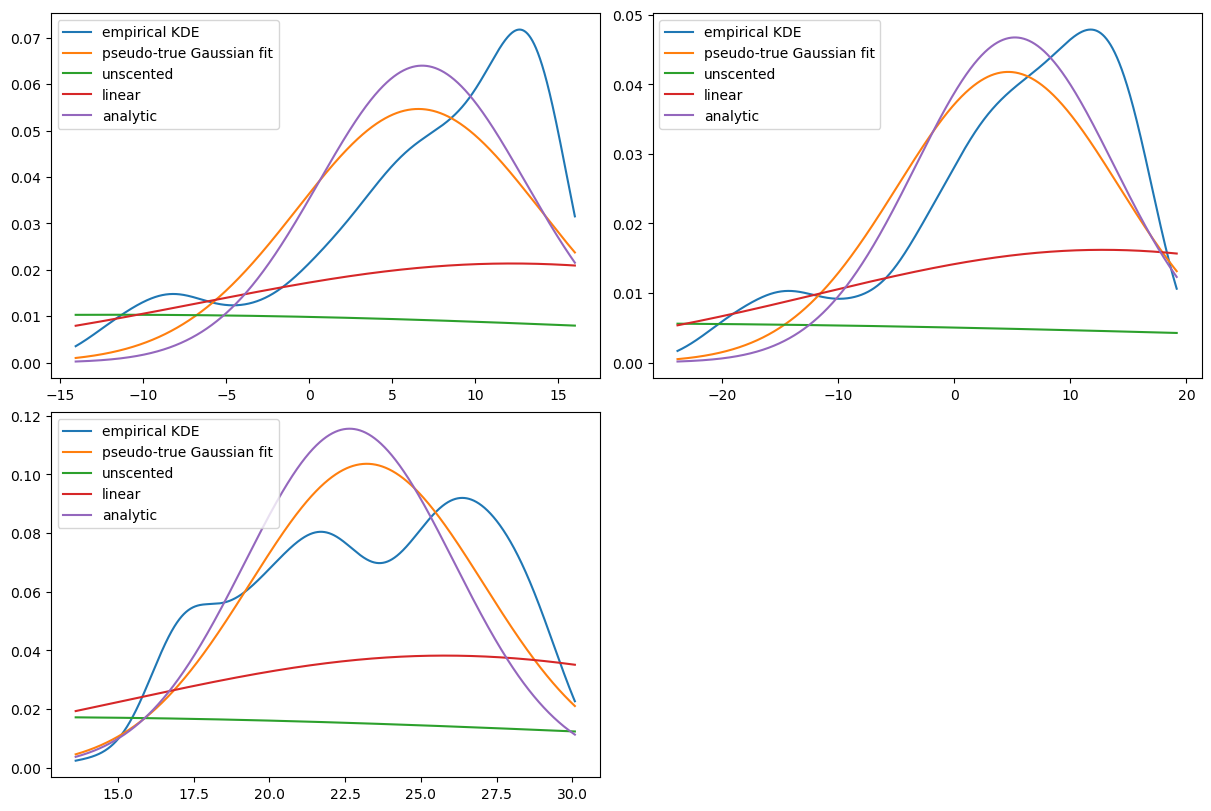

In [24]:
fig = Figure(figsize=(12, 8), dpi=100, constrained_layout=1)
for i in range(3):
    ax = fig.add_subplot(2, 2, i + 1)
    grid = np.linspace(np.min(output_samples[:, i]), np.max(output_samples[:, i]), 2000)
    ax.plot(
        grid,
        scipy.stats.gaussian_kde(output_samples[:, i].reshape(-1))(grid),
        label="empirical KDE",
    )
    for label, μ, Σ, linestyle in (
        ("pseudo-true Gaussian fit", μ_monte_carlo, Σ_monte_carlo, "-"),
        ("unscented", μ_unscented, Σ_unscented, "-"),
        ("linear", μ_linear, Σ_linear, "-"),
        ("analytic", μ_analytic, Σ_analytic, "-"),
    ):
        ax.plot(
            grid,
            scipy.stats.norm.pdf(grid, loc=μ[i], scale=Σ[i, i] ** 0.5),
            label=label,
            linestyle=linestyle,
        )
    ax.legend()

fig

# Kalman filter example
## Generate data

In [25]:
from probit_network import rectify_eigenvalues

In [26]:
@equinox.filter_jit
def schur_complement(A, B, C, x, y, method=1):
    """Returns a numerically stable(ish) attempt at
    x + B C^(-1) y,
    A - B C^(-1) B^T.
    """
    if method == 1:
        # C = U U^T
        U = jax.scipy.linalg.cholesky(C)
        # B_tilde = B U^-T
        B_tilde = jax.scipy.linalg.solve_triangular(U, B.T, trans=1, lower=False).T
        return (
            x + B_tilde @ jax.scipy.linalg.solve_triangular(U, y, lower=False),
            rectify_eigenvalues(A - B_tilde.dot(B_tilde.T)),
        )

In [27]:
n_x = 3
n_u = 0
n_y = 1

F = network
H = ProbitLinearNetwork(
    ProbitLinear.create_linear(
        in_size=n_x + n_u,
        out_size=n_y,
        C=np.eye(n_x)[(0,), :],
        d=np.zeros((n_y)),
    )
)
H_aug = H.augment_with_identity()

In [31]:
sim_horizon = 1000
R = jnp.eye(n_y) * 1e-2

In [32]:
process_noise_keys = jax.random.split(jax.random.PRNGKey(122), sim_horizon)

In [33]:
with jax.default_device(jax.devices("cpu")[0]):
    ϵ = jax.random.multivariate_normal(
        mean=jnp.zeros(n_y), cov=R, key=jax.random.PRNGKey(124), shape=sim_horizon
    )

In [34]:
x = np.ones((sim_horizon, n_x))
x[0] = [-8.0, 1.0, 27.0]
y = np.zeros((sim_horizon, n_y))
y_noiseless = np.zeros((sim_horizon, n_y))
for i in trange(1, sim_horizon):
    x[i, :] = F_true(x[i - 1, :], process_noise_keys[i - 1], **lorenz_args)
    y_noiseless[i, :] = H(x[i, :])
    y[i, :] = y_noiseless[i, :] + ϵ[i]

  0%|          | 0/999 [00:00<?, ?it/s]

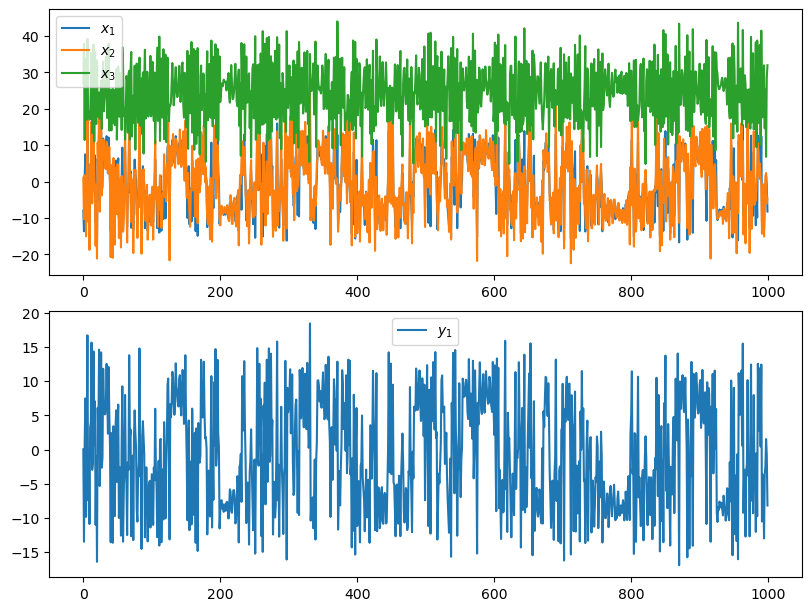

In [35]:
fig = Figure(figsize=(8, 6), dpi=100, constrained_layout=1)
ax = fig.add_subplot(211)
for i in range(n_x):
    ax.plot(x[:, i], label=rf"$x_{i+1}$")
ax.legend()
ax = fig.add_subplot(212)
for i in range(n_y):
    ax.plot(y[:, i], label=rf"$y_{i+1}$")
ax.legend()
fig

## Filtering

In [74]:
method = "analytic"

# method = "linear"

# method = "unscented"

In [75]:
# data-driven Q
Q = Q_0

# eyeballed Q
# Q = np.eye(n_x) * 5

In [76]:
STATES = slice(None, n_x)
INPUTS = slice(n_x, n_x + n_u)
OUTPUTS = slice(n_x + n_u, None)
JOINT = slice(None, n_x + n_u + n_y)

joint_prediction = np.zeros((sim_horizon, n_x + n_u + n_y))
x_post = np.zeros((sim_horizon, n_x))
P_pred = np.zeros((sim_horizon, n_x + n_u + n_y, n_x + n_u + n_y))
P_post = np.zeros((sim_horizon, n_x, n_x))

joint_prediction[0, STATES] = x[0]
P_pred[0, STATES, STATES] = Q * 1
P_post[0, STATES, STATES] = Q * 1

In [77]:
for i in trange(1, sim_horizon):
    # predict x[i | i - 1] using x[i - 1 | i - 1]
    joint_prediction[i, STATES], P_pred[i, STATES, STATES] = F.propagate_mean_cov(
        x_post[i - 1, STATES],
        P_post[i - 1, STATES, STATES],
        method=method,
    )
    P_pred[i, STATES, STATES] += Q
    # predict y[i | i - 1] using x[i | i - 1]
    joint_prediction[i, JOINT], P_pred[i, JOINT, JOINT] = H_aug.propagate_mean_cov(
        joint_prediction[i, STATES],
        P_pred[i, STATES, STATES],
        method=method,
    )
    P_pred[i, OUTPUTS, OUTPUTS] += R
    # correct x[i | i - 1] to x[i | i]
    x_post[i, STATES], P_post[i, STATES, STATES] = schur_complement(
        P_pred[i, STATES, STATES],
        P_pred[i, STATES, OUTPUTS],
        P_pred[i, OUTPUTS, OUTPUTS],
        joint_prediction[i, STATES],
        y[i, :] - joint_prediction[i, OUTPUTS],
    )
    if np.any(np.isnan(joint_prediction[i])):
        print("Halting due to NaN at time step", i)
        break
else:
    print("Filtering successful")
    x_pred = joint_prediction[:, STATES]
    x_pred_std = jax.vmap(jnp.diag)(P_pred[:, STATES, STATES]) ** 0.5
    y_pred = joint_prediction[:, OUTPUTS]
    y_pred_std = jax.vmap(jnp.diag)(P_pred[:, OUTPUTS, OUTPUTS]) ** 0.5
    print(
        "rms(predicted x - true x) / std(true x)",
        ((x - x_pred) ** 2).mean(axis=0) ** 0.5 / x.std(axis=0),
    )

  0%|          | 0/999 [00:00<?, ?it/s]

Filtering successful
rms(predicted x - true x) / std(true x) [0.79413227 0.90358648 0.76900649]


In [78]:
time_slice = slice(-100, None)

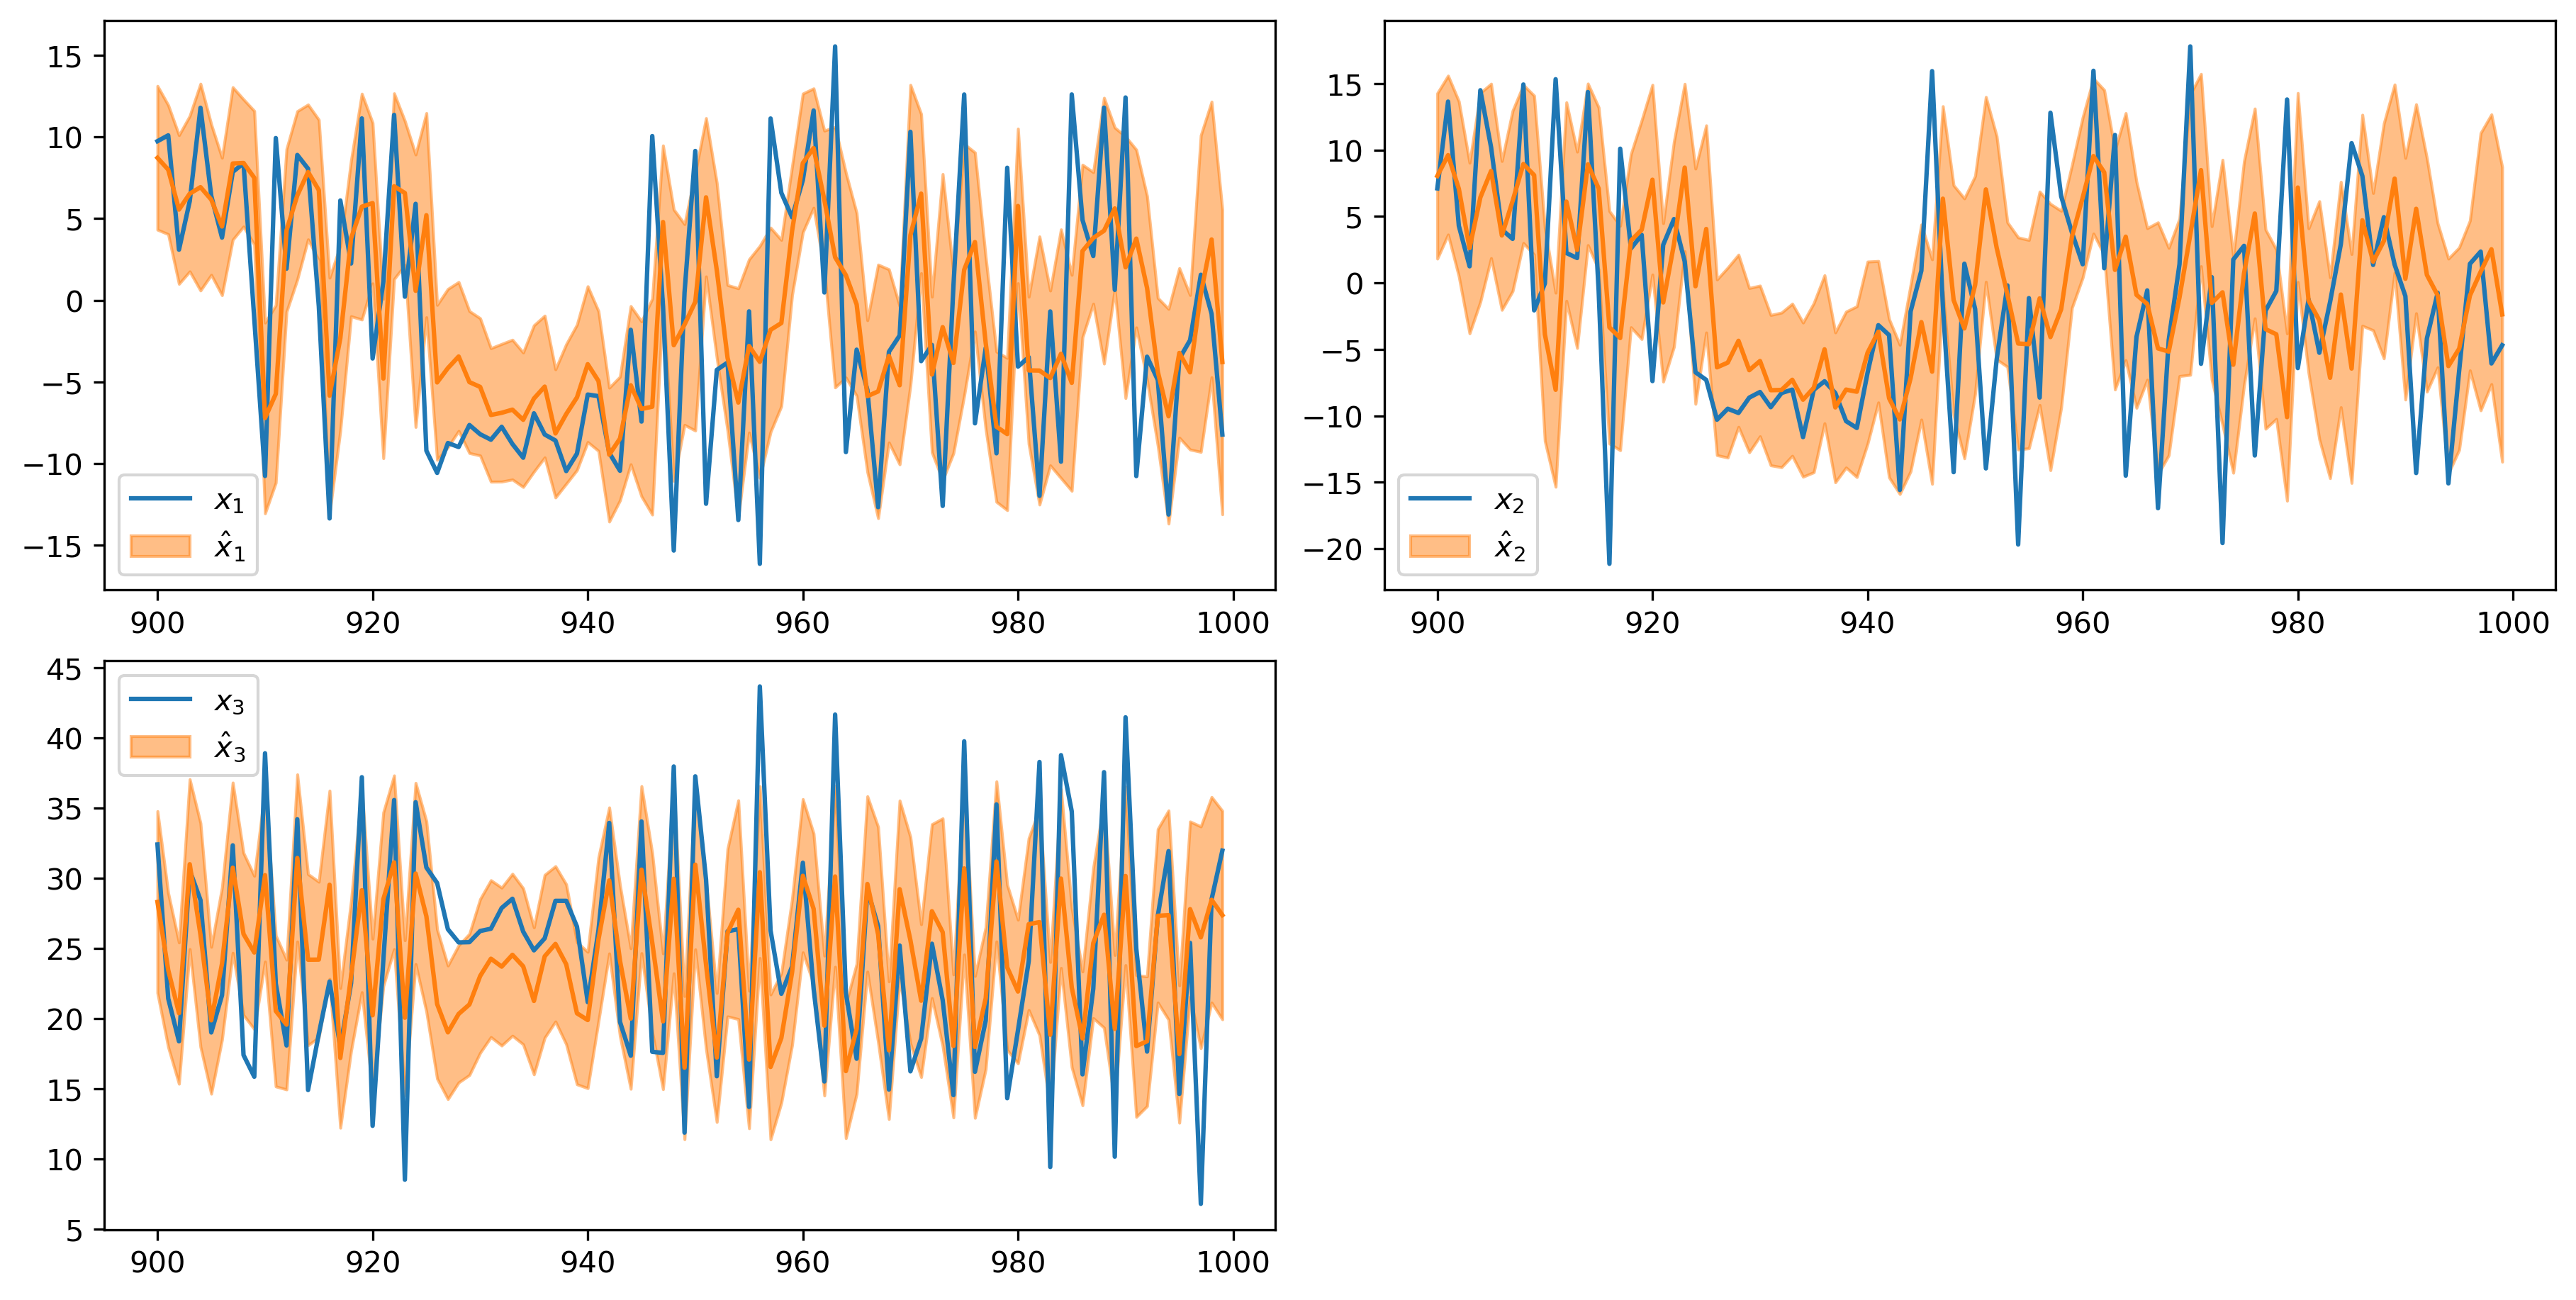

In [79]:
fig = Figure(figsize=(12, 6), dpi=300, constrained_layout=1)
for i in range(n_x):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.plot(np.arange(sim_horizon)[time_slice], x[time_slice, i], label=rf"$x_{i+1}$")
    ax.plot(np.arange(sim_horizon)[time_slice], x_pred[time_slice, i])
    ax.fill_between(
        np.arange(sim_horizon)[time_slice],
        (x_pred[time_slice, i] - x_pred_std[time_slice, i]),
        (x_pred[time_slice, i] + x_pred_std[time_slice, i]),
        color="C1",
        alpha=0.5,
        label=rf"$\hat x_{i+1}$",
    )
    ax.legend()
# fig.savefig(f"figures/kalman/state-trajectory-{method}.pdf")
fig

In [80]:
x_pred_t = ((x - x_pred) / x_pred_std)[1:, :]

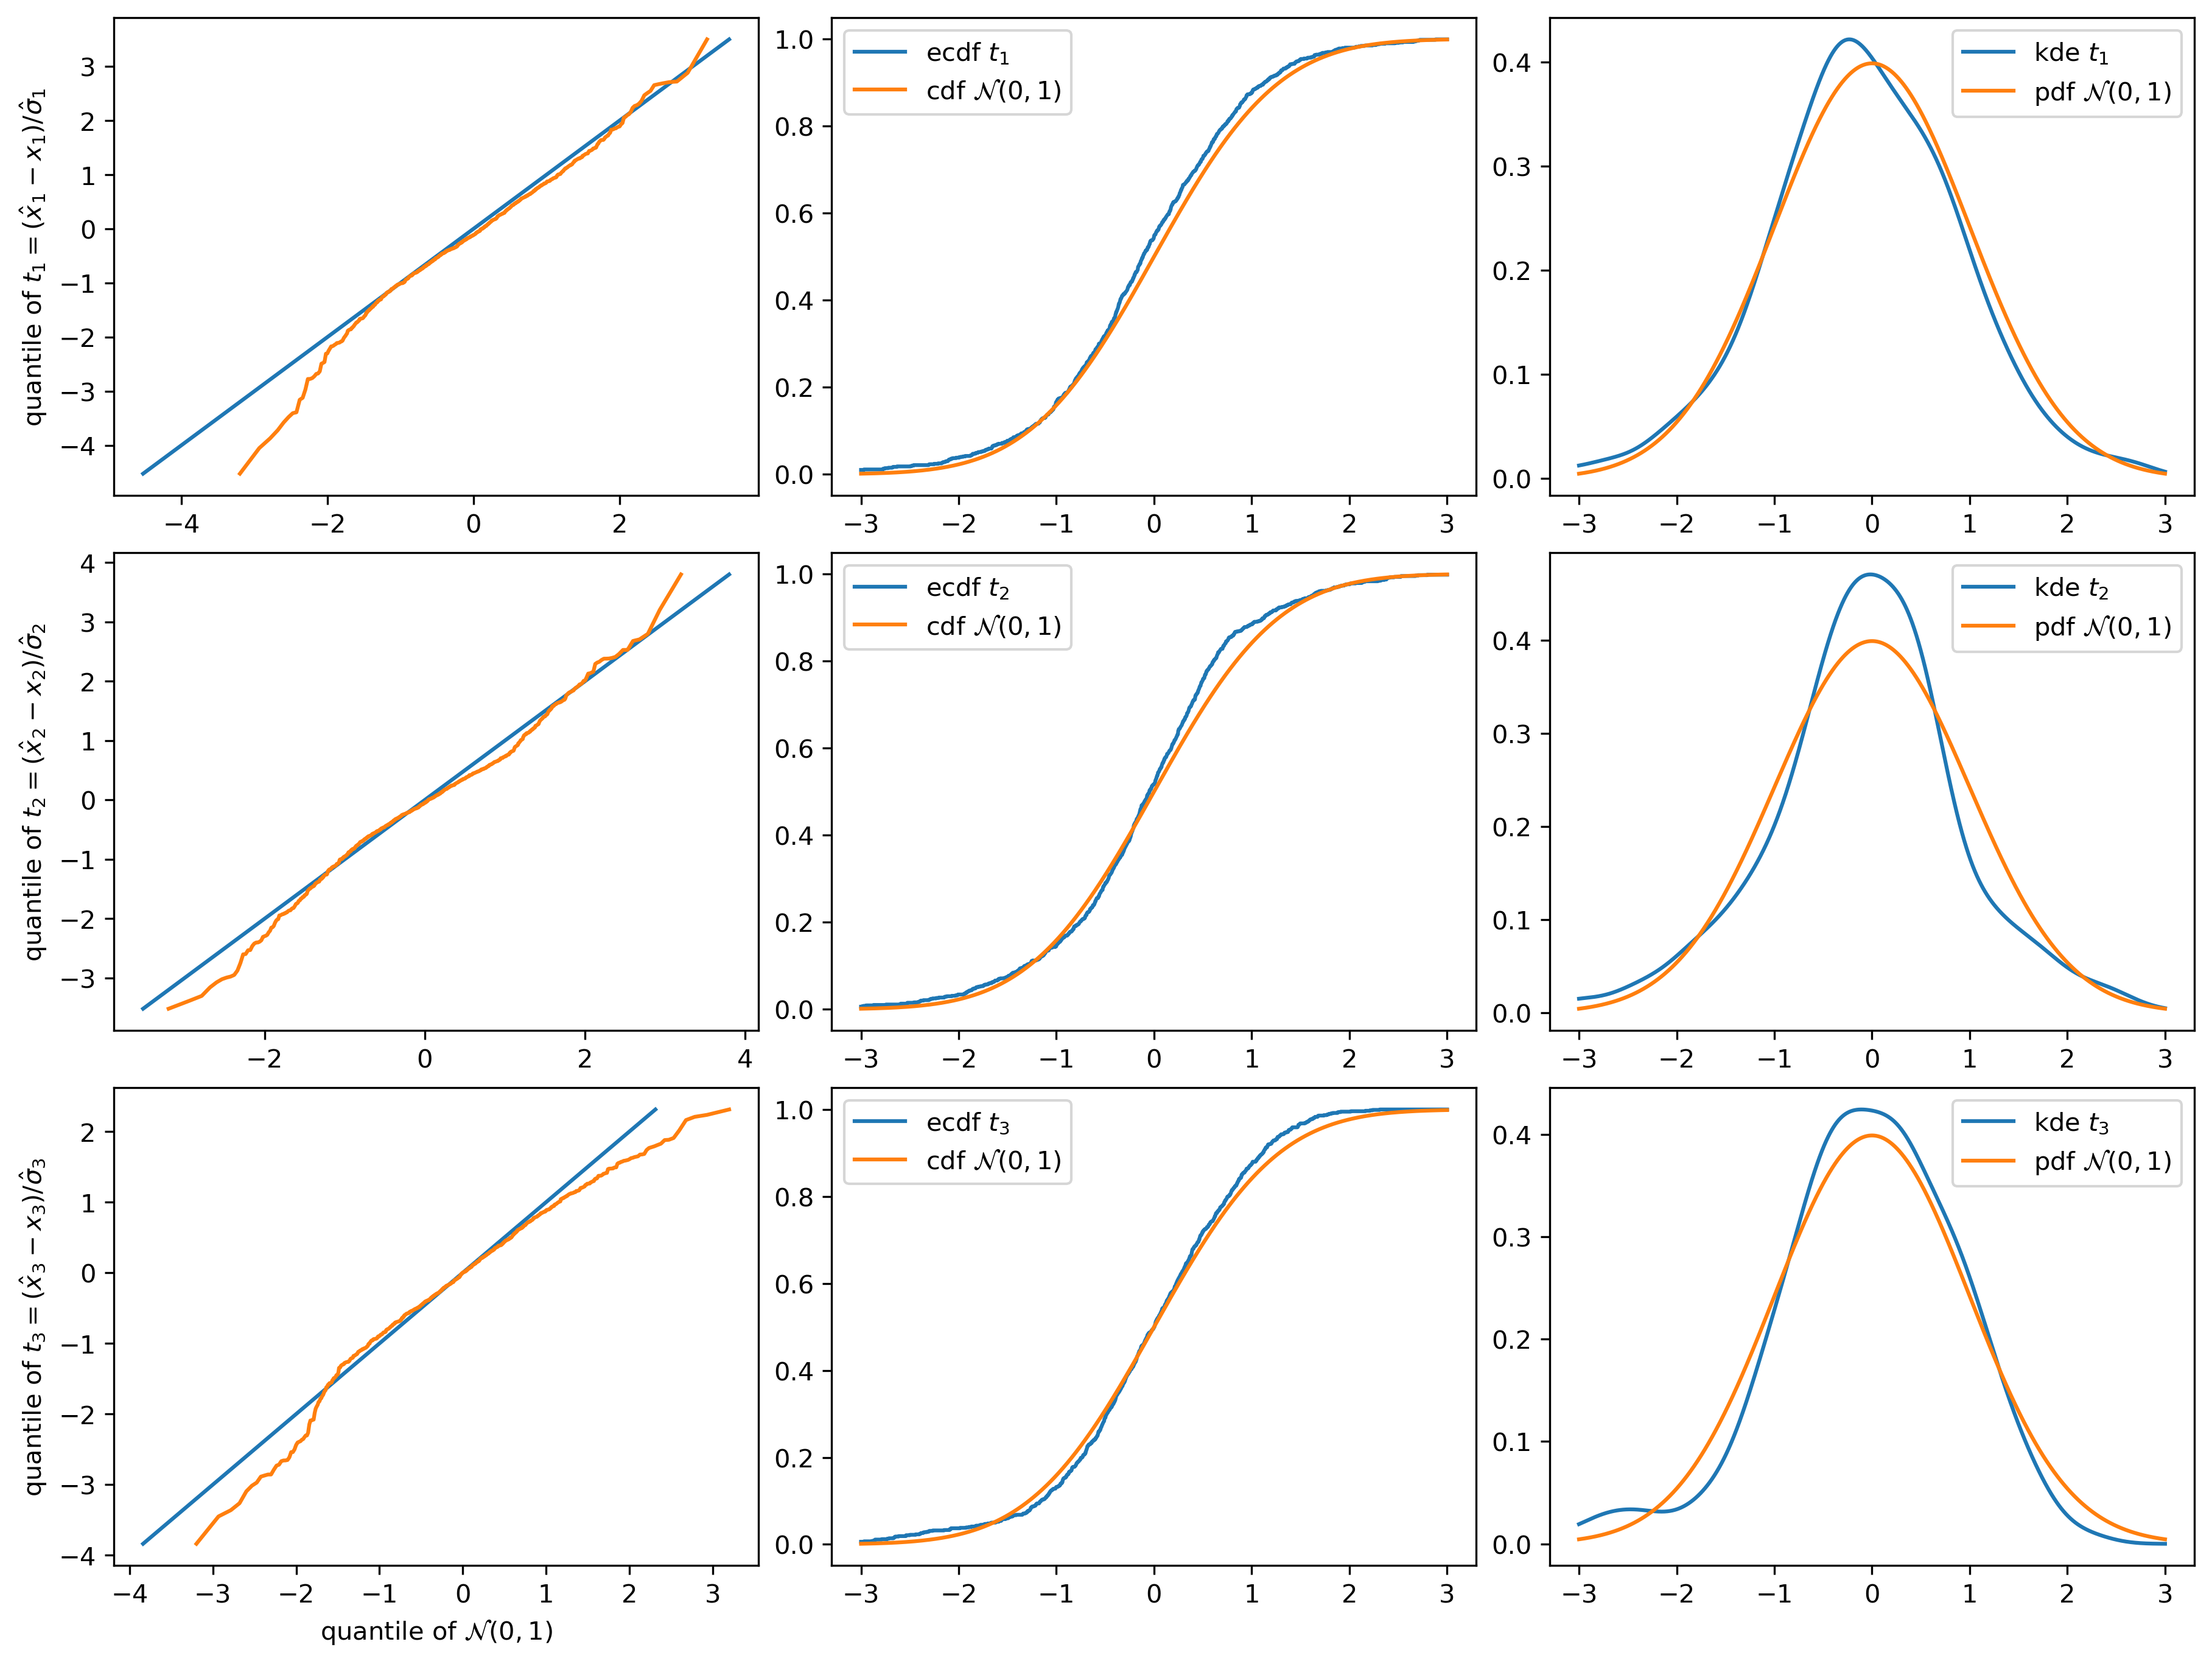

In [81]:
fig = Figure(figsize=(12, 9), dpi=300, constrained_layout=1)
for i in range(n_x):
    quantiles_theoretical, quantiles_empirical = scipy.stats.probplot(
        x_pred_t[:, i], fit=False, dist=scipy.stats.norm(0, 1)
    )
    ax = fig.add_subplot(3, 3, 3 * i + 1)
    ax.plot(quantiles_empirical, quantiles_empirical)
    ax.plot(quantiles_theoretical, quantiles_empirical)
    if i == 2:
        ax.set_xlabel(r"quantile of $\mathcal {N}(0, 1)$")
    ax.set_ylabel(
        rf"quantile of $t_{i+1} = (\hat x_{i+1} - x_{i+1})/ \hat\sigma_{i+1}$"
    )

    t_grid = np.linspace(-3, 3, 2000)
    ax = fig.add_subplot(3, 3, 3 * i + 2)
    ax.plot(
        t_grid,
        scipy.stats.ecdf(x_pred_t[:, i]).cdf.evaluate(t_grid),
        label=rf"ecdf $t_{i+1}$",
    )
    ax.plot(
        t_grid,
        scipy.stats.norm.cdf(t_grid),
        label=r"cdf $\mathcal {N}(0, 1)$",
    )
    ax.legend()

    ax = fig.add_subplot(3, 3, 3 * i + 3)
    ax.plot(
        t_grid,
        scipy.stats.gaussian_kde(x_pred_t[:, i])(t_grid),
        label=rf"kde $t_{i+1}$",
    )
    ax.plot(
        t_grid,
        scipy.stats.norm.pdf(t_grid),
        label=r"pdf $\mathcal{N}(0, 1)$",
    )
    ax.legend()
# fig.savefig(f"figures/kalman/calibration-{method}.pdf")
fig

In [82]:
x_pred_χ2 = jax.vmap(lambda residual, cov: residual @ jnp.linalg.solve(cov, residual))(
    x_pred[1:, :] - x[1:, :], P_pred[1:, STATES, STATES]
)

In [83]:
x_pred_χ2_sorted = sorted(x_pred_χ2)
x_pred_χ2_empirical_percentage_points = scipy.stats.mstats.meppf(x_pred_χ2_sorted)
x_pred_χ2_theoretical_percentage_points = scipy.stats.chi2(3).cdf(x_pred_χ2_sorted)

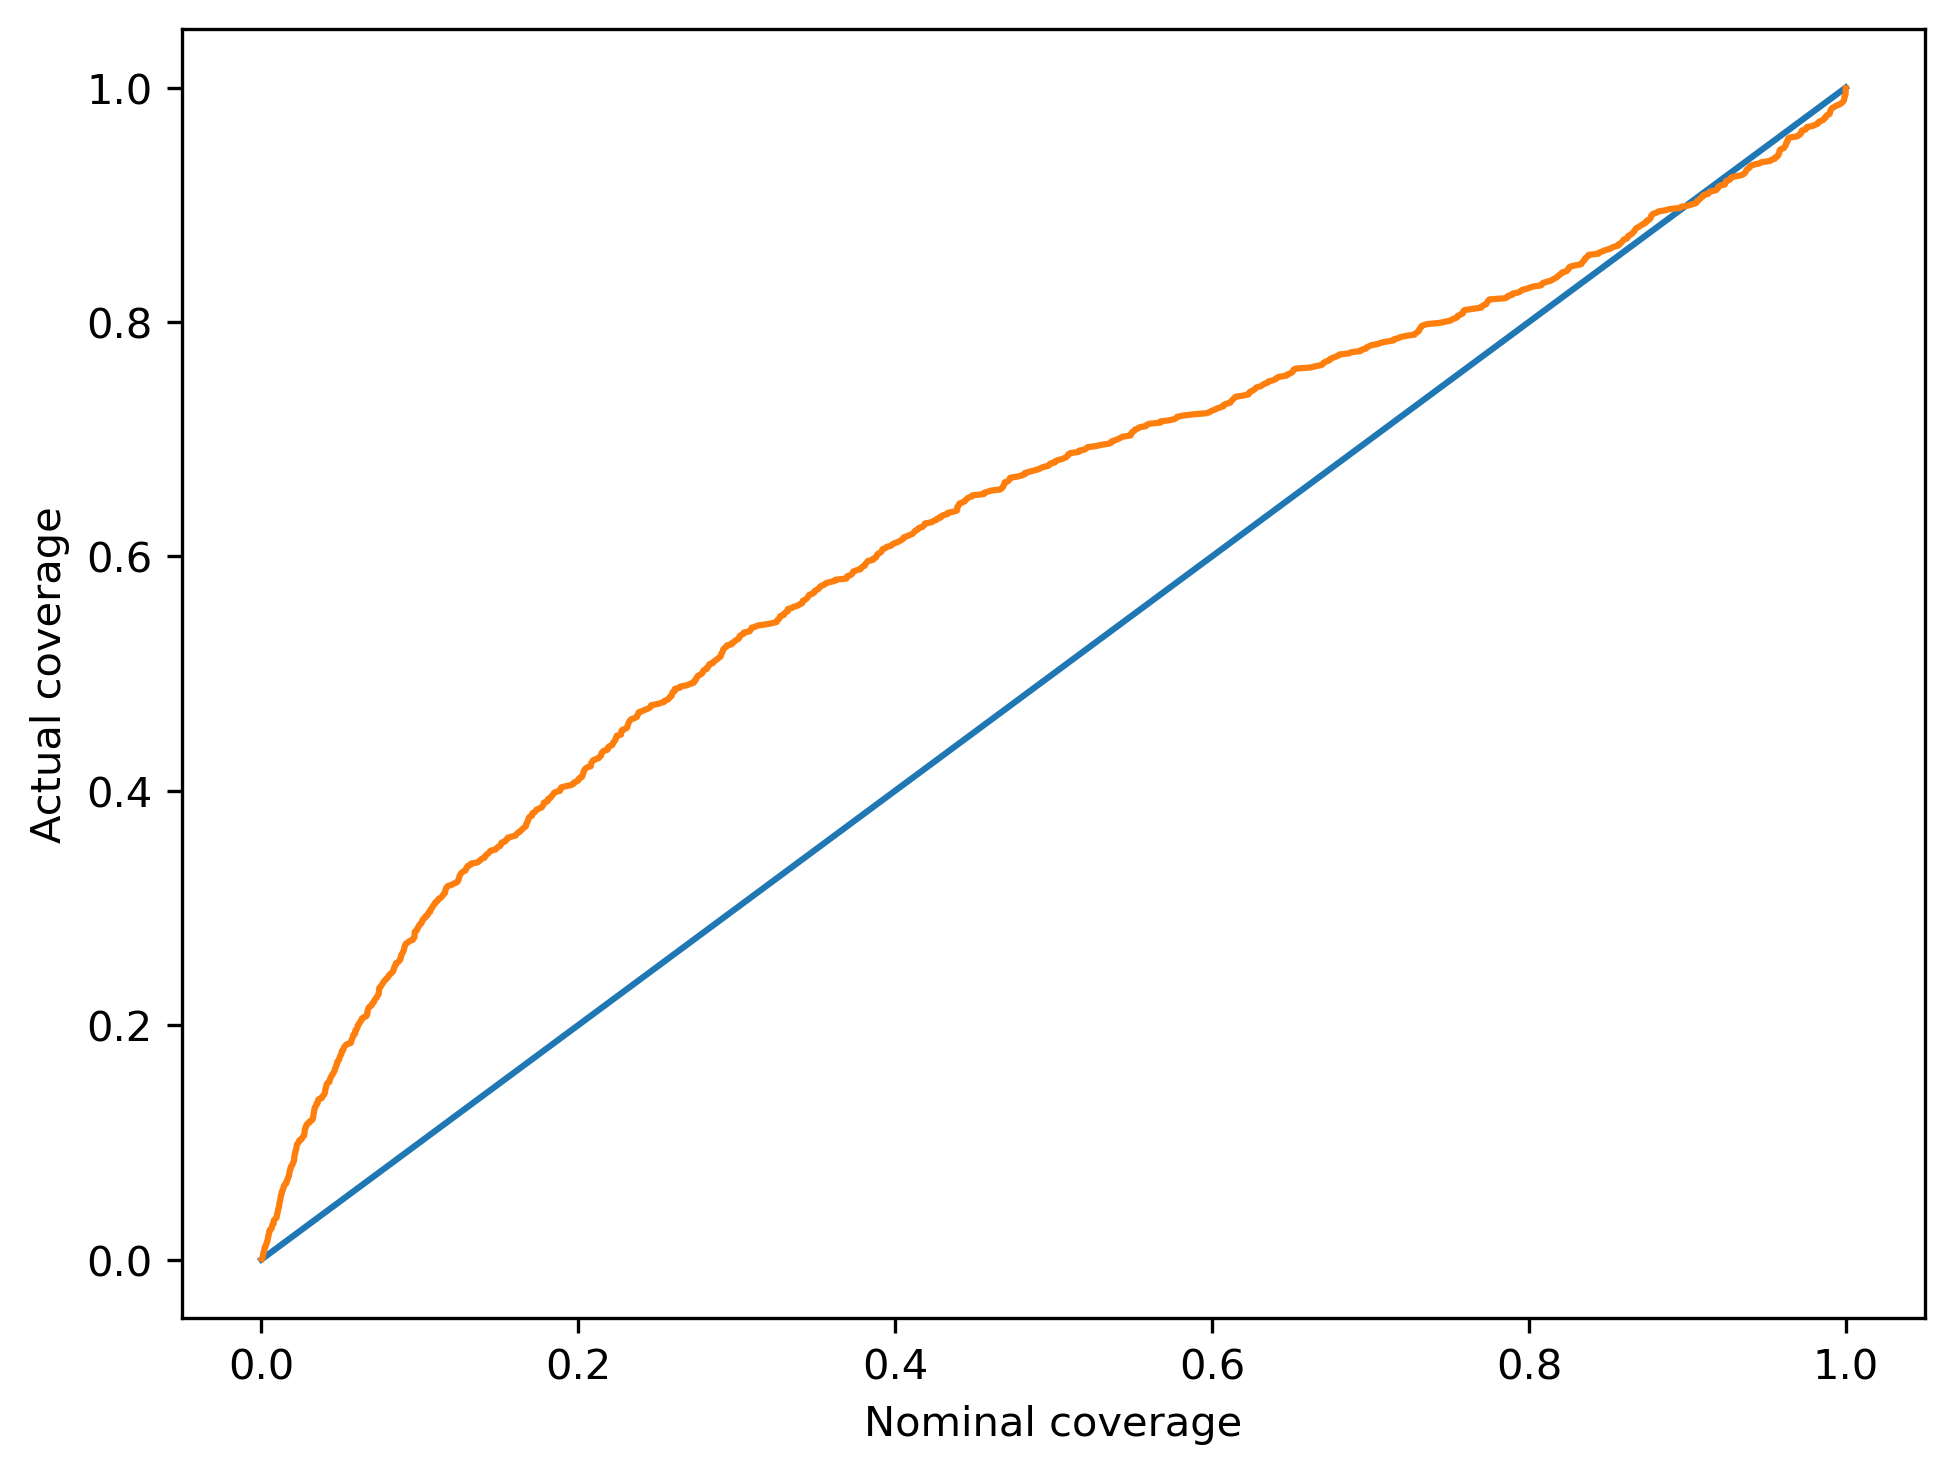

In [84]:
fig = Figure(dpi=300, constrained_layout=1)
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1])
ax.plot(x_pred_χ2_theoretical_percentage_points, x_pred_χ2_empirical_percentage_points)
ax.set_xlabel("Nominal coverage")
ax.set_ylabel("Actual coverage")
# fig.savefig(f"figures/kalman/coverage-{method}.pdf")
fig